In [ ]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# for basic SMILES operations, descriptors and fingerprints
!pip install -q rdkit-pypi

# for graphs
!pip install -q dgl

# for mol2vec
!pip install -q mol2vec

# for protein features
!pip install Bio
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.2 MB/s eta 0:00:00


In [ ]:
#@title Imports of Required Librarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import statistics
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew

# for basic SMILES operations, descriptors and fingerprints
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys, AllChem, Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges

# for graphs
import torch

# for mol2vec
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

# for chemical language models
from transformers import AutoModel, AutoTokenizer

# for Target Protein features
from Bio.PDB import *
import re


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [ ]:
import json

with open('kaggle.json', 'r') as f:
    kaggle_json = json.load(f)

import os

os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
os.environ['KAGGLE_KEY'] = kaggle_json['key']

In [ ]:
#@title Getting the Kaggle Dataset

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the competition data
api.competition_download_files('leash-BELKA', path='./kaggle_data')

# Unzip the downloaded file
import zipfile
with zipfile.ZipFile('./kaggle_data/leash-BELKA.zip', 'r') as zip_ref:
    zip_ref.extractall('./kaggle_data')


In [ ]:
#@title Checking First 1,000,000 Entries

# Load a sample of the training data
df = pd.read_csv('./kaggle_data/train.csv', nrows=1000000)

# Separate the dataset into binding and non-binding examples
df_bind = df[df['binds'] == 1]
df_no_bind = df[df['binds'] == 0]

# Determine the number of samples to take (minimum of 500 or half of the smaller group)
n_samples = min(500, len(df_bind), len(df_no_bind))

# Randomly sample an equal number from each group
df_bind_sample = df_bind.sample(n_samples, random_state=42)
df_no_bind_sample = df_no_bind.sample(n_samples, random_state=42)

# Combine the samples
df = pd.concat([df_bind_sample, df_no_bind_sample]).reset_index(drop=True)

# Shuffle the combined dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows and the distribution of the 'binds' column
print(df.head())
print("\nDistribution of 'binds' column:")
print(df['binds'].value_counts(normalize=True))

# Display the first few rows
df.head()

        id                            buildingblock1_smiles  \
0  8846314   C=CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  4653019    C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  8157741  C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  3565117   C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21   
4  6248316  C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

     buildingblock2_smiles      buildingblock3_smiles  \
0           CCSC1CCC1(O)CN          Cc1ccc(CN)c(Cl)n1   
1            COc1cncc(N)c1   Cl.Cl.NCc1nccn1-c1ccccc1   
2        Cl.Cn1cc(N)ccc1=O                 Cc1nnsc1CN   
3            COc1cncc(N)n1  NCc1ccc(NC(=O)c2ccco2)cc1   
4  NCc1cc(-c2ccccc2)[nH]n1      CN(C)c1ncccc1CN.Cl.Cl   

                                     molecule_smiles protein_name  binds  
0  C=CC[C@@H](Nc1nc(NCc2ccc(C)nc2Cl)nc(NCC2(O)CCC...          HSA      0  
1  C#CC[C@H](Nc1nc(NCc2nccn2-c2ccccc2)nc(Nc2cncc(...          HSA      1  
2  C=CCC[C@@H](Nc1nc(NCc2snnc2C)nc(Nc2ccc(=O)n(C)... 

id                            buildingblock1_smiles  \
0  8846314   C=CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  4653019    C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  8157741  C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  3565117   C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21   
4  6248316  C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

     buildingblock2_smiles      buildingblock3_smiles  \
0           CCSC1CCC1(O)CN          Cc1ccc(CN)c(Cl)n1   
1            COc1cncc(N)c1   Cl.Cl.NCc1nccn1-c1ccccc1   
2        Cl.Cn1cc(N)ccc1=O                 Cc1nnsc1CN   
3            COc1cncc(N)n1  NCc1ccc(NC(=O)c2ccco2)cc1   
4  NCc1cc(-c2ccccc2)[nH]n1      CN(C)c1ncccc1CN.Cl.Cl   

                                     molecule_smiles protein_name  binds  
0  C=CC[C@@H](Nc1nc(NCc2ccc(C)nc2Cl)nc(NCC2(O)CCC...          HSA      0  
1  C#CC[C@H](Nc1nc(NCc2nccn2-c2ccccc2)nc(Nc2cncc(...          HSA      1  
2  C=CCC[C@@H](Nc1nc(NCc2snnc2C)nc(Nc2ccc(=O)n(C)...         BRD4      1  
3  C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCc2ccc(NC(=O)c3cc...          HSA      1  
4  C=CCC(CC=C)(Nc1nc(NCc2cc(-c3ccccc3)[nH]n2)nc(N...         BRD4      0

In [ ]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     20000 non-null  int64 
 1   buildingblock1_smiles  20000 non-null  object
 2   buildingblock2_smiles  20000 non-null  object
 3   buildingblock3_smiles  20000 non-null  object
 4   molecule_smiles        20000 non-null  object
 5   protein_name           20000 non-null  object
 6   binds                  20000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.1+ MB
None


In [ ]:
#@title Getting All Unique Joint Molecules

# assign unique molecule_smiles values to variable. This is all we need for the purpose of this demo
smiles = df['molecule_smiles'].unique()
print(len(smiles))

19661


In [ ]:
# obtain RDKit mol objects from SMILES
mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

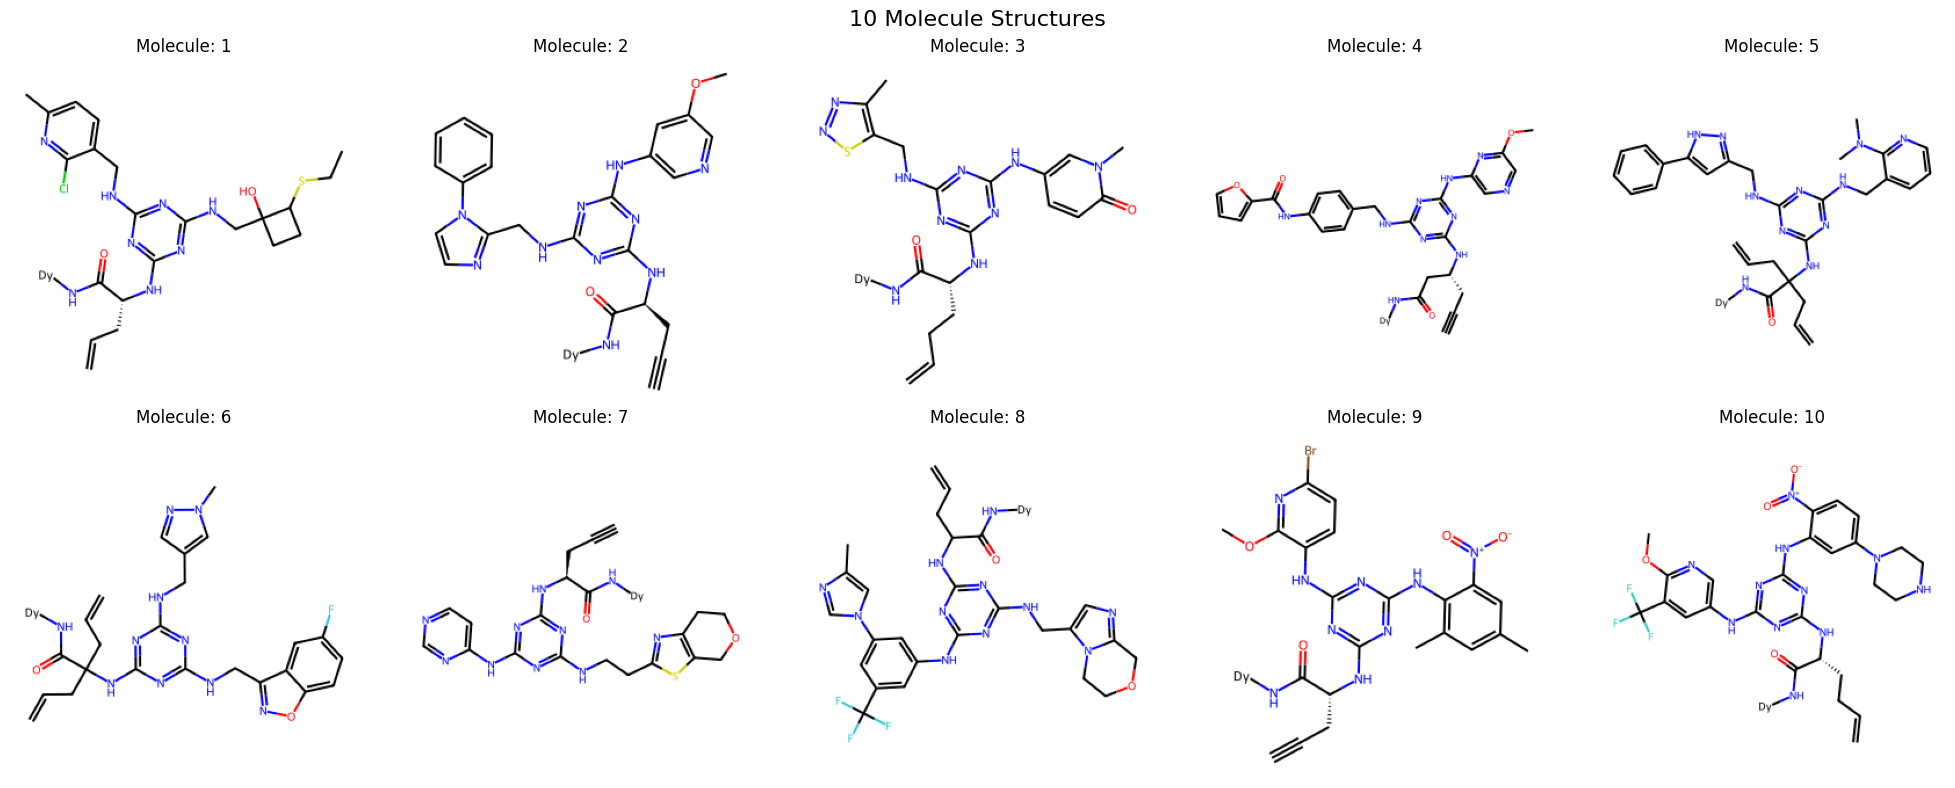

In [18]:
#@title Plotting Some Joint Molecules

fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
fig.suptitle("10 Molecule Structures", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Draw each molecule
for i, mol in enumerate(mols[:10]):  # Limit to first 10 molecules
    img = Draw.MolToImage(mol)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Molecule: {i+1}")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
#@title Creating Joint Molecule Feature DF with RDKit Descriptors

def generate_descriptors(mols):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

    mol_descriptors = []
    for mol in mols:
        rdkit_descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(rdkit_descriptors)

    desc_names = calc.GetDescriptorNames()
    return pd.DataFrame(mol_descriptors, columns=desc_names)

descriptor_df = generate_descriptors(mols)
descriptor_df

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0           12.265342       -0.817331          12.265342           0.178329   
1           12.279322       -0.735125          12.279322           0.139598   
2           12.308944       -0.561030          12.308944           0.134840   
3           12.194836       -0.417784          12.194836           0.120114   
4           13.028187       -1.087932          13.028187           0.212953   
...               ...             ...                ...                ...   
19656       12.154962       -0.737340          12.154962           0.065949   
19657       12.158714       -2.548818          12.158714           0.018345   
19658       12.130579       -0.759683          12.130579           0.020352   
19659       12.353414       -0.589706          12.353414           0.206257   
19660       12.916330       -1.109859          12.916330           0.060580   

            qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0      0.160236  668.556         638.316  669.119271                  193   
1      0.179336  646.016         622.832  647.129720                  191   
2      0.232537  618.028         594.844  619.101791                  177   
3      0.128735  704.052         678.852  705.135199                  213   
4      0.115166  715.167         680.895  716.223955                  221   
...         ...      ...             ...         ...                  ...   
19656  0.210646  603.379         584.227  604.075432                  169   
19657  0.114201  619.962         592.746  621.141508                  187   
19658  0.148067  618.003         590.787  619.155935                  185   
19659  0.189603  648.032         622.832  649.145370                  193   
19660  0.122025  732.972         702.732  733.091599                  205   

       NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                        0  ...           1             0           0   
1                        0  ...           0             0           0   
2                        0  ...           0             0           0   
3                        0  ...           0             0           0   
4                        0  ...           0             0           0   
...                    ...  ...         ...           ...         ...   
19656                    0  ...           0             0           0   
19657                    0  ...           0             0           0   
19658                    0  ...           0             0           0   
19659                    0  ...           0             0           0   
19660                    0  ...           0             0           0   

       fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                      0             0            0            0   
1                      1             0            0            0   
2                      0             0            0            0   
3                      1             0            0            0   
4                      0             0            0            0   
...                  ...           ...          ...          ...   
19656                  1             0            0            0   
19657                  1             0            0            0   
19658                  1             0            0            0   
19659                  0             0            0            0   
19660                  0             0            0            0   

       fr_thiophene  fr_unbrch_alkane  fr_urea  
0                 0                 0        0  
1                 0                 0        0  
2                 0                 0        0  
3                 0                 0        0  
4                 0                 0        0  
...             ...               ...      ...  
19656             0                 0        0  
19657             0                 4        0 

In [ ]:
smiles_to_descriptors = dict(zip(smiles, descriptor_df.to_dict('records')))

def add_molecule_features(row):
    mol_features = smiles_to_descriptors[row['molecule_smiles']]
    for key, value in mol_features.items():
        row[f'mol_{key}'] = value
    return row

df = df.apply(add_molecule_features, axis=1)
df.head()

id                            buildingblock1_smiles  \
0  8846314   C=CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  4653019    C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  8157741  C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  3565117   C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21   
4  6248316  C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

     buildingblock2_smiles      buildingblock3_smiles  \
0           CCSC1CCC1(O)CN          Cc1ccc(CN)c(Cl)n1   
1            COc1cncc(N)c1   Cl.Cl.NCc1nccn1-c1ccccc1   
2        Cl.Cn1cc(N)ccc1=O                 Cc1nnsc1CN   
3            COc1cncc(N)n1  NCc1ccc(NC(=O)c2ccco2)cc1   
4  NCc1cc(-c2ccccc2)[nH]n1      CN(C)c1ncccc1CN.Cl.Cl   

                                     molecule_smiles protein_name  binds  \
0  C=CC[C@@H](Nc1nc(NCc2ccc(C)nc2Cl)nc(NCC2(O)CCC...          HSA      0   
1  C#CC[C@H](Nc1nc(NCc2nccn2-c2ccccc2)nc(Nc2cncc(...          HSA      1   
2  C=CCC[C@@H](Nc1nc(NCc2snnc2C)nc(Nc2ccc(=O)n(C)...         BRD4      1   
3  C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCc2ccc(NC(=O)c3cc...          HSA      1   
4  C=CCC(CC=C)(Nc1nc(NCc2cc(-c3ccccc3)[nH]n2)nc(N...         BRD4      0   

   mol_MaxEStateIndex  mol_MinEStateIndex  mol_MaxAbsEStateIndex  ...  \
0           12.265342           -0.817331              12.265342  ...   
1           12.279322           -0.735125              12.279322  ...   
2           12.308944           -0.561030              12.308944  ...   
3           12.194836           -0.417784              12.194836  ...   
4           13.028187           -1.087932              13.028187  ...   

   mol_fr_sulfide  mol_fr_sulfonamd  mol_fr_sulfone  mol_fr_term_acetylene  \
0               1                 0               0                      0   
1               0                 0               0                      1   
2               0                 0               0                      0   
3               0                 0               0                      1   
4               0                 0               0                      0   

   mol_fr_tetrazole  mol_fr_thiazole  mol_fr_thiocyan  mol_fr_thiophene  \
0                 0                0                0                 0   
1                 0                0                0                 0   
2                 0                0                0                 0   
3                 0                0                0                 0   
4                 0                0                0                 0   

   mol_fr_unbrch_alkane  mol_fr_urea  
0                     0            0  
1                     0            0  
2                     0            0  
3                     0            0  
4                     0            0  

[5 rows x 215 columns]

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 215 entries, id to mol_fr_urea
dtypes: float64(104), int64(106), object(5)
memory usage: 32.8+ MB
None


In [ ]:
def get_atoms_and_positions(mols):
    results = []
    for mol in mols:
        if mol is not None:
            # Add hydrogens to the molecule
            mol = Chem.AddHs(mol)

            # Generate a 3D conformation
            AllChem.EmbedMolecule(mol, randomSeed=42)

            # Optimize the structure
            AllChem.MMFFOptimizeMolecule(mol)

            # Get atom symbols and positions
            conf = mol.GetConformer()
            atoms_and_positions = [
                (atom.GetSymbol(), conf.GetAtomPosition(atom.GetIdx()))
                for atom in mol.GetAtoms()
            ]
            results.append(atoms_and_positions)
        else:
            results.append(None)

    return results

# Example usage:
# Assuming you have your SMILES in a list or Series called 'smiles'
# smiles = ["CC(=O)OC1=CC=CC=C1C(=O)O", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", ...]
# mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

atoms_and_positions_list = get_atoms_and_positions(mols[:1])

# Print results for the first molecule (if available)
if atoms_and_positions_list and atoms_and_positions_list[0]:
    print("Atoms and positions for the first molecule:")
    for atom, position in atoms_and_positions_list[0]:
        print(f"{atom}: ({position.x:.3f}, {position.y:.3f}, {position.z:.3f})")

[08:57:07] UFFTYPER: Unrecognized charge state for atom: 34
[08:57:07] UFFTYPER: Unrecognized atom type: Dy5+3 (34)


Atoms and positions for the first molecule:
C: (-0.863, -5.638, 2.148)
C: (-1.924, -4.867, 2.000)
C: (-2.541, -4.660, 0.673)
C: (-2.485, -3.180, 0.366)
N: (-1.142, -2.733, 0.350)
C: (-0.738, -1.390, 0.097)
N: (-1.620, -0.412, -0.154)
C: (-1.282, 0.864, -0.398)
N: (-2.240, 1.882, -0.660)
C: (-3.616, 1.518, -0.662)
C: (-4.596, 2.562, -0.936)
C: (-4.238, 3.849, -1.187)
C: (-5.248, 4.777, -1.439)
C: (-6.564, 4.400, -1.433)
C: (-7.652, 5.359, -1.696)
N: (-6.878, 3.111, -1.179)
C: (-5.943, 2.190, -0.933)
Cl: (-6.392, 0.530, -0.607)
N: (0.035, 1.135, -0.380)
C: (0.945, 0.171, -0.131)
N: (2.353, 0.488, -0.118)
C: (3.324, -0.545, 0.148)
C: (4.705, 0.050, 0.099)
O: (4.995, 0.610, -1.142)
C: (4.943, 0.963, 1.274)
C: (5.677, -0.166, 1.960)
C: (5.793, -0.861, 0.637)
S: (7.314, -0.612, -0.249)
C: (8.096, 0.974, -0.109)
C: (8.632, 1.193, 1.281)
N: (0.561, -1.092, 0.108)
C: (-3.179, -3.017, -0.950)
O: (-2.447, -2.503, -1.871)
N: (-4.454, -3.405, -1.060)
Dy: (-5.236, -3.032, -3.185)
H: (-0.435, -6.133,

In [ ]:
def get_detailed_atom_features(mols):
    results = []
    for mol in mols:
        if mol is not None:
            # Add hydrogens to the molecule
            mol = Chem.AddHs(mol)

            # Try to generate a 3D conformation
            try:
                AllChem.EmbedMolecule(mol, randomSeed=42)
                AllChem.MMFFOptimizeMolecule(mol)
            except:
                print("MMFF94 failed, trying UFF...")
                AllChem.EmbedMolecule(mol, randomSeed=42)
                AllChem.UFFOptimizeMolecule(mol, maxIters=200)

            # Compute Gasteiger charges
            ComputeGasteigerCharges(mol)

            # Get atom features
            conf = mol.GetConformer()
            atom_features = []
            for atom in mol.GetAtoms():
                position = conf.GetAtomPosition(atom.GetIdx())
                if position.x != 0 or position.y != 0 or position.z != 0:
                    features = {
                        'symbol': atom.GetSymbol(),
                        'position': (position.x, position.y, position.z),
                        'atomic_number': atom.GetAtomicNum(),
                        'degree': atom.GetDegree(),
                        'formal_charge': atom.GetFormalCharge(),
                        'hybridization': str(atom.GetHybridization()),
                        'is_aromatic': atom.GetIsAromatic(),
                        'is_in_ring': atom.IsInRing(),
                        'total_num_Hs': atom.GetTotalNumHs(),
                        'gasteiger_charge': atom.GetDoubleProp('_GasteigerCharge'),
                        'mass': atom.GetMass(),
                        'valence': atom.GetTotalValence(),
                        'implicit_valence': atom.GetImplicitValence(),
                        'explicit_valence': atom.GetExplicitValence(),
                        'chirality': str(atom.GetChiralTag())
                    }
                    atom_features.append(features)
                else:
                    print(f"Warning: Atom {atom.GetSymbol()} (index {atom.GetIdx()}) has coordinates (0,0,0). It may not have been placed correctly.")

            results.append(atom_features)
        else:
            results.append(None)

    return results

# Example usage:
# Assuming you have your SMILES in a list or Series called 'smiles'
# smiles = ["CC(=O)OC1=CC=CC=C1C(=O)O", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", ...]
# mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

detailed_atom_features = get_detailed_atom_features(mols[:1])

# Print results for the first atom of the first molecule (if available)
if detailed_atom_features and detailed_atom_features[0]:
    print("Detailed features for the first atom of the first molecule:")
    for key, value in detailed_atom_features[0][0].items():
        print(f"{key}: {value}")
else:
    print("No data available for the first molecule")

[08:57:08] UFFTYPER: Unrecognized charge state for atom: 34
[08:57:08] UFFTYPER: Unrecognized atom type: Dy5+3 (34)


Detailed features for the first atom of the first molecule:
symbol: C
position: (-0.8634780997067228, -5.638251572375861, 2.148448253118881)
atomic_number: 6
degree: 3
formal_charge: 0
hybridization: SP2
is_aromatic: False
is_in_ring: False
total_num_Hs: 0
gasteiger_charge: nan
mass: 12.011
valence: 4
implicit_valence: 0
explicit_valence: 4
chirality: CHI_UNSPECIFIED


In [20]:
def detailed_ss_prediction(phi, psi):
    if phi is None or psi is None:
        return '-'
    phi, psi = np.degrees(phi), np.degrees(psi)
    if -70 <= phi <= -30 and -70 <= psi <= -30:
        return 'H'  # Alpha helix
    elif -80 <= phi <= -20 and 120 <= psi <= 180:
        return 'G'  # 3-10 helix
    elif -180 <= phi <= -45 and 90 <= psi <= 180:
        return 'E'  # Extended strand
    elif -180 <= phi <= -45 and -50 <= psi <= 50:
        return 'B'  # Isolated beta-bridge
    elif -90 <= phi <= 0 and 0 <= psi <= 120:
        return 'T'  # Turn
    elif (phi <= -100 and 120 <= psi <= 180) or (phi >= 100 and 120 <= psi <= 180):
        return 'S'  # Bend
    else:
        return 'C'  # Coil

def calculate_exposure(residue):
    if "CA" not in residue:
        return None
    ca_atom = residue["CA"]
    center = ca_atom.coord
    neighbor_count = sum(1 for atom in residue.get_parent().get_atoms()
                         if atom.name == "CA" and np.linalg.norm(atom.coord - center) < 10)
    return neighbor_count

def extract_alphafold_features(pdb_file):
    parser = PDBParser()
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]

    features = {}
    ss_counts = {'-': 0, 'H': 0, 'G': 0, 'E': 0, 'B': 0, 'T': 0, 'S': 0, 'C': 0}
    exposure_scores = []
    plddt_scores = []

    # Assign detailed secondary structure
    ppb = PPBuilder()
    total_residues = 0
    for pp in ppb.build_peptides(structure):
        phi_psi = pp.get_phi_psi_list()
        for i, residue in enumerate(pp):
            total_residues += 1
            phi, psi = phi_psi[i]
            ss = detailed_ss_prediction(phi, psi)
            ss_counts[ss] += 1

            if "CA" in residue:
                plddt_scores.append(residue["CA"].get_bfactor())

            exposure = calculate_exposure(residue)
            if exposure is not None:
                exposure_scores.append(exposure)

    # Calculate secondary structure composition
    for ss, count in ss_counts.items():
        features[f"ss_{ss}"] = (count / total_residues) * 100

    # Calculate exposure and pLDDT statistics
    features['max_exposure'] = max(exposure_scores) if exposure_scores else np.nan
    features['min_exposure'] = min(exposure_scores) if exposure_scores else np.nan
    features['mean_exposure'] = np.mean(exposure_scores) if exposure_scores else np.nan
    features['max_plddt'] = max(plddt_scores) if plddt_scores else np.nan
    features['min_plddt'] = min(plddt_scores) if plddt_scores else np.nan
    features['mean_plddt'] = np.mean(plddt_scores) if plddt_scores else np.nan

    return features

# Usage
protein_files = {
    'sEH': "AF-P34913-F1-model_v4.pdb",
    'BRD4': "AF-O60885-F1-model_v4.pdb",
    'HSA': "AF-P02768-F1-model_v4.pdb"
}

protein_features = {name: extract_alphafold_features(file) for name, file in protein_files.items()}

# Print secondary structure composition for each protein
for protein, features in protein_features.items():
    print(f"\nSecondary Structure Composition of {protein}:")
    for ss in ['-', 'H', 'G', 'E', 'B', 'T', 'S', 'C']:
        print(f"{ss}: {features[f'ss_{ss}']:.2f}%")
    print(f"Max Exposure: {features['max_exposure']}")
    print(f"Min Exposure: {features['min_exposure']}")
    print(f"Mean Exposure: {features['mean_exposure']:.2f}")
    print(f"Max pLDDT: {features['max_plddt']}")
    print(f"Min pLDDT: {features['min_plddt']}")
    print(f"Mean pLDDT: {features['mean_plddt']:.2f}")

# Add protein features to the dataframe
for feature in protein_features['sEH'].keys():
    df[feature] = df['protein_name'].map(lambda x: protein_features[x][feature])


Secondary Structure Composition of sEH:
-: 0.36%
H: 32.97%
G: 11.35%
E: 21.98%
B: 24.68%
T: 0.54%
S: 0.18%
C: 7.93%
Max Exposure: 31
Min Exposure: 6
Mean Exposure: 18.77
Max pLDDT: 98.96
Min pLDDT: 34.52
Mean pLDDT: 93.38

Secondary Structure Composition of BRD4:
-: 0.15%
H: 17.25%
G: 9.91%
E: 30.18%
B: 12.41%
T: 1.10%
S: 1.91%
C: 27.09%
Max Exposure: 29
Min Exposure: 3
Mean Exposure: 8.97
Max pLDDT: 98.59
Min pLDDT: 26.47
Mean pLDDT: 55.01

Secondary Structure Composition of HSA:
-: 0.33%
H: 58.29%
G: 7.88%
E: 4.76%
B: 24.30%
T: 0.16%
S: 0.00%
C: 4.27%
Max Exposure: 33
Min Exposure: 6
Mean Exposure: 17.91
Max pLDDT: 98.63
Min pLDDT: 30.13
Mean pLDDT: 92.75


<ipython-input-20-9f1bbfb80d9b>:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature] = df['protein_name'].map(lambda x: protein_features[x][feature])
<ipython-input-20-9f1bbfb80d9b>:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature] = df['protein_name'].map(lambda x: protein_features[x][feature])
<ipython-input-20-9f1bbfb80d9b>:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [21]:
# Display the first few rows of the updated dataframe
df.head()

id                            buildingblock1_smiles  \
0  8846314   C=CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  4653019    C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  8157741  C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  3565117   C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21   
4  6248316  C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

     buildingblock2_smiles      buildingblock3_smiles  \
0           CCSC1CCC1(O)CN          Cc1ccc(CN)c(Cl)n1   
1            COc1cncc(N)c1   Cl.Cl.NCc1nccn1-c1ccccc1   
2        Cl.Cn1cc(N)ccc1=O                 Cc1nnsc1CN   
3            COc1cncc(N)n1  NCc1ccc(NC(=O)c2ccco2)cc1   
4  NCc1cc(-c2ccccc2)[nH]n1      CN(C)c1ncccc1CN.Cl.Cl   

                                     molecule_smiles protein_name  binds  \
0  C=CC[C@@H](Nc1nc(NCc2ccc(C)nc2Cl)nc(NCC2(O)CCC...          HSA      0   
1  C#CC[C@H](Nc1nc(NCc2nccn2-c2ccccc2)nc(Nc2cncc(...          HSA      1   
2  C=CCC[C@@H](Nc1nc(NCc2snnc2C)nc(Nc2ccc(=O)n(C)...         BRD4      1   
3  C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCc2ccc(NC(=O)c3cc...          HSA      1   
4  C=CCC(CC=C)(Nc1nc(NCc2cc(-c3ccccc3)[nH]n2)nc(N...         BRD4      0   

   mol_MaxEStateIndex  mol_MinEStateIndex  mol_MaxAbsEStateIndex  ...  \
0           12.265342           -0.817331              12.265342  ...   
1           12.279322           -0.735125              12.279322  ...   
2           12.308944           -0.561030              12.308944  ...   
3           12.194836           -0.417784              12.194836  ...   
4           13.028187           -1.087932              13.028187  ...   

        ss_B      ss_T      ss_S       ss_C  max_exposure  min_exposure  \
0  24.302135  0.164204  0.000000   4.269294            33             6   
1  24.302135  0.164204  0.000000   4.269294            33             6   
2  12.408223  1.101322  1.908957  27.092511            29             3   
3  24.302135  0.164204  0.000000   4.269294            33             6   
4  12.408223  1.101322  1.908957  27.092511            29             3   

   mean_exposure  max_plddt  min_plddt  mean_plddt  
0      17.906404      98.63      30.13   92.752677  
1      17.906404      98.63      30.13   92.752677  
2       8.969163      98.59      26.47   55.011535  
3      17.906404      98.63      30.13   92.752677  
4       8.969163      98.59      26.47   55.011535  

[5 rows x 229 columns]

In [22]:
# Check for any remaining NaN values
print(df.isna().sum())

id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
                        ..
min_exposure             0
mean_exposure            0
max_plddt                0
min_plddt                0
mean_plddt               0
Length: 229, dtype: int64


In [23]:
# # Usage
# sEH_features = extract_alphafold_features("/AF-P34913-F1-model_v4.pdb")
# BRD4_features = extract_alphafold_features("/AF-O60885-F1-model_v4.pdb")
# HSA_features = extract_alphafold_features("/AF-P02768-F1-model_v4.pdb")

# # Print a few features as an example
# # for key in list(ephx2_features.keys())[0:]:
# #     print(f"{key}: {ephx2_features[key]}")
# # for key in list(brd4_features.keys())[0:]:
# #     print(f"{key}: {brd4_features[key]}")
# # for key in list(alb_features.keys())[0:]:
# #     print(f"{key}: {alb_features[key]}")


# # Calculate and print secondary structure composition
# ss_composition_sEH = {}
# for value in sEH_features.values():
#     if isinstance(value, str) and len(value) == 1:
#         ss_composition_sEH[value] = ss_composition_sEH.get(value, 0) + 1

# total = sum(ss_composition_sEH.values())
# print("\nSecondary Structure Composition of sEH:")
# for ss, count in ss_composition_sEH.items():
#     percentage = (count / total) * 100
#     print(f"{ss}: {percentage:.2f}%")

# ss_composition_BRD4 = {}
# for value in BRD4_features.values():
#     if isinstance(value, str) and len(value) == 1:
#         ss_composition_BRD4[value] = ss_composition_BRD4.get(value, 0) + 1

# total = sum(ss_composition_BRD4.values())
# print("\nSecondary Structure Composition of BRD4:")
# for ss, count in ss_composition_BRD4.items():
#     percentage = (count / total) * 100
#     print(f"{ss}: {percentage:.2f}%")

# ss_composition_HSA = {}
# for value in HSA_features.values():
#     if isinstance(value, str) and len(value) == 1:
#         ss_composition_HSA[value] = ss_composition_HSA.get(value, 0) + 1

# total = sum(ss_composition_HSA.values())
# print("\nSecondary Structure Composition of HSA:")
# for ss, count in ss_composition_HSA.items():
#     percentage = (count / total) * 100
#     print(f"{ss}: {percentage:.2f}%")

In [24]:
# # We create a dictionary to store all our protein data
# protein_data = {
#     'sEH': sEH_features,
#     'BRD4': BRD4_features,
#     'HSA': HSA_features
# }

# # Function to extract exposure scores
# def extract_exposure_scores(features):
#     return {int(key.split('_')[1]): value for key, value in features.items() if key.endswith('_exposure')}

# # Function to calculate secondary structure composition
# def calculate_ss_composition(features):
#     ss_composition = {}
#     for value in features.values():
#         if isinstance(value, str) and len(value) == 1:
#             ss_composition[value] = ss_composition.get(value, 0) + 1
#     total = sum(ss_composition.values())
#     return {ss: (count / total) * 100 for ss, count in ss_composition.items()}

# # Function to calculate exposure score statistics
# def calculate_exposure_stats(exposure_scores):
#     scores = list(exposure_scores.values())
#     return {
#         'mean': statistics.mean(scores),
#         'median': statistics.median(scores),
#         'max': max(scores),
#         'min': min(scores)
#     }

# # Process each protein
# for protein_name, features in protein_data.items():
#     # Extract exposure scores
#     exposure_scores = extract_exposure_scores(features)

#     # Calculate secondary structure composition
#     ss_composition = calculate_ss_composition(features)

#     # Calculate exposure score statistics
#     exposure_stats = calculate_exposure_stats(exposure_scores)

#     # Store processed data back in the dictionary
#     protein_data[protein_name] = {
#         'features': features,
#         'exposure_scores': exposure_scores,
#         'ss_composition': ss_composition,
#         'exposure_stats': exposure_stats
#     }

# # Now you can easily access the data for each protein
# for protein_name, data in protein_data.items():
#     print(f"\n{protein_name}:")
#     print("Secondary Structure Composition:")
#     for ss, percentage in data['ss_composition'].items():
#         print(f"{ss}: {percentage:.2f}%")

#     print("\nExposure Score Statistics:")
#     for stat, value in data['exposure_stats'].items():
#         print(f"{stat.capitalize()}: {value:.2f}")

#     print("\nExposure Scores (first 5):")
#     for residue, score in list(data['exposure_scores'].items())[:5]:
#         print(f"Residue {residue}: {score}")

# # If you want to access the original features, you can do:
# # ephx2_features = protein_data['EPHX2']['features']
# # And so on for other proteins

# Data Analysis and Adjustments

In [25]:
# List of columns to drop
columns_to_drop = ['id', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles', 'molecule_smiles', 'protein_name']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

In [26]:
# Display the first few rows and info of the modified dataframe with only numerical inputs
df.head()

binds  mol_MaxEStateIndex  mol_MinEStateIndex  mol_MaxAbsEStateIndex  \
0      0           12.265342           -0.817331              12.265342   
1      1           12.279322           -0.735125              12.279322   
2      1           12.308944           -0.561030              12.308944   
3      1           12.194836           -0.417784              12.194836   
4      0           13.028187           -1.087932              13.028187   

   mol_MinAbsEStateIndex   mol_qed  mol_MolWt  mol_HeavyAtomMolWt  \
0               0.178329  0.160236    668.556             638.316   
1               0.139598  0.179336    646.016             622.832   
2               0.134840  0.232537    618.028             594.844   
3               0.120114  0.128735    704.052             678.852   
4               0.212953  0.115166    715.167             680.895   

   mol_ExactMolWt  mol_NumValenceElectrons  ...       ss_B      ss_T  \
0      669.119271                      193  ...  24.302135  0.164204   
1      647.129720                      191  ...  24.302135  0.164204   
2      619.101791                      177  ...  12.408223  1.101322   
3      705.135199                      213  ...  24.302135  0.164204   
4      716.223955                      221  ...  12.408223  1.101322   

       ss_S       ss_C  max_exposure  min_exposure  mean_exposure  max_plddt  \
0  0.000000   4.269294            33             6      17.906404      98.63   
1  0.000000   4.269294            33             6      17.906404      98.63   
2  1.908957  27.092511            29             3       8.969163      98.59   
3  0.000000   4.269294            33             6      17.906404      98.63   
4  1.908957  27.092511            29             3       8.969163      98.59   

   min_plddt  mean_plddt  
0      30.13   92.752677  
1      30.13   92.752677  
2      26.47   55.011535  
3      30.13   92.752677  
4      26.47   55.011535  

[5 rows x 223 columns]

In [27]:
#@title Explore Data

print(f'{df.shape}\n, {df.info()}\n, {df.describe().T}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 223 entries, binds to mean_plddt
dtypes: float64(116), int64(107)
memory usage: 34.0 MB


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(20000, 223)
, None
,                          count       mean        std           min        25%  \
binds                  20000.0   0.500000   0.500013  0.000000e+00   0.000000   
mol_MaxEStateIndex     20000.0  12.744710   0.751433  1.169286e+01  12.230869   
mol_MinEStateIndex     20000.0  -1.074943   1.047297 -5.920474e+00  -1.048962   
mol_MaxAbsEStateIndex  20000.0  12.744710   0.751433  1.169286e+01  12.230869   
mol_MinAbsEStateIndex  20000.0   0.093228   0.062314  1.933169e-07   0.034656   
...                        ...        ...        ...           ...        ...   
min_exposure           20000.0   4.997250   1.415218  3.000000e+00   3.000000   
mean_exposure          20000.0  15.176719   4.412594  8.969163e+00   8.969163   
max_plddt              20000.0  98.714723   0.160402  9.859000e+01  98.590000   
min_plddt              20000.0  30.211573   3.193739  2.647000e+01  26.470000   
mean_plddt             20000.0  80.325157  17.938637  5.501153e+01  55.011535   

     

In [28]:
# Identify zero-variance features
zero_var_features = df.columns[df.var() == 0]

print("Features with zero variance:", zero_var_features)

# Remove zero-variance features for plotting
df_plot = df.drop(columns=zero_var_features)

Features with zero variance: Index(['mol_NumRadicalElectrons', 'mol_SMR_VSA8', 'mol_SlogP_VSA9',
       'mol_fr_Al_COO', 'mol_fr_ArN', 'mol_fr_Ar_COO', 'mol_fr_COO',
       'mol_fr_COO2', 'mol_fr_C_S', 'mol_fr_azide', 'mol_fr_azo',
       'mol_fr_barbitur', 'mol_fr_benzodiazepine', 'mol_fr_diazo',
       'mol_fr_dihydropyridine', 'mol_fr_epoxide', 'mol_fr_guanido',
       'mol_fr_hdrzine', 'mol_fr_isocyan', 'mol_fr_isothiocyan',
       'mol_fr_lactam', 'mol_fr_nitroso', 'mol_fr_phos_acid',
       'mol_fr_phos_ester', 'mol_fr_prisulfonamd', 'mol_fr_quatN',
       'mol_fr_thiocyan'],
      dtype='object')


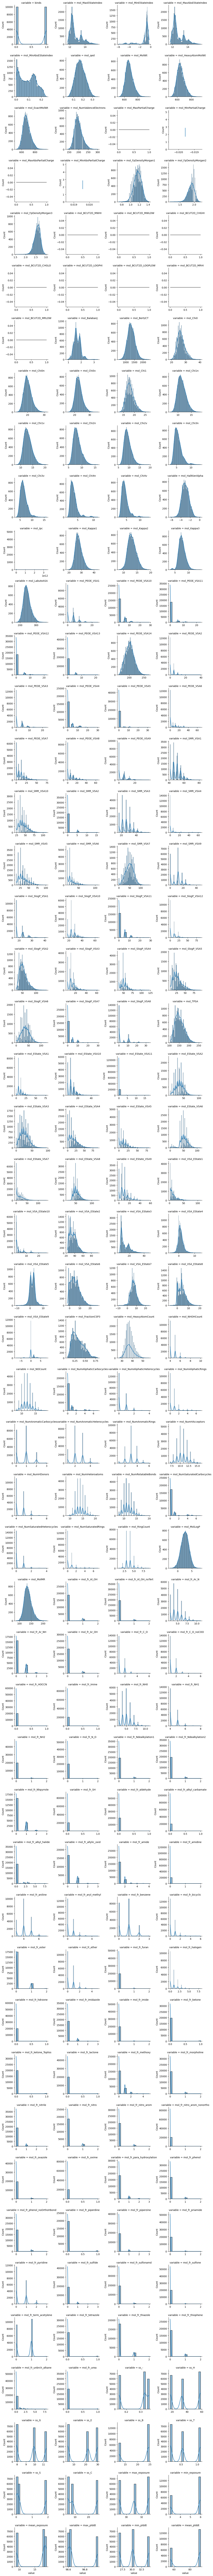

In [29]:
f = pd.melt(frame=df_plot)
g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, 'value', kde=True)

In [30]:
print(df_plot['binds'].value_counts(), df_plot['ss_C'].value_counts())

binds
0    10000
1    10000
Name: count, dtype: int64 ss_C
4.269294     7370
27.092511    6685
7.927928     5945
Name: count, dtype: int64


In [31]:
# Remove columns with infinity values
df_cleaned = df_plot.select_dtypes(exclude=['object']).replace([np.inf, -np.inf], np.nan).dropna(axis=1)

removed_columns = set(df_plot.columns) - set(df_cleaned.columns)
print("Columns removed due to infinity values:", removed_columns)

Columns removed due to infinity values: {'mol_MinAbsPartialCharge', 'mol_BCUT2D_MRHI', 'mol_BCUT2D_MWLOW', 'mol_MaxPartialCharge', 'mol_BCUT2D_CHGHI', 'mol_BCUT2D_LOGPHI', 'mol_BCUT2D_LOGPLOW', 'mol_BCUT2D_CHGLO', 'mol_BCUT2D_MWHI', 'mol_BCUT2D_MRLOW', 'mol_MaxAbsPartialCharge', 'mol_MinPartialCharge'}


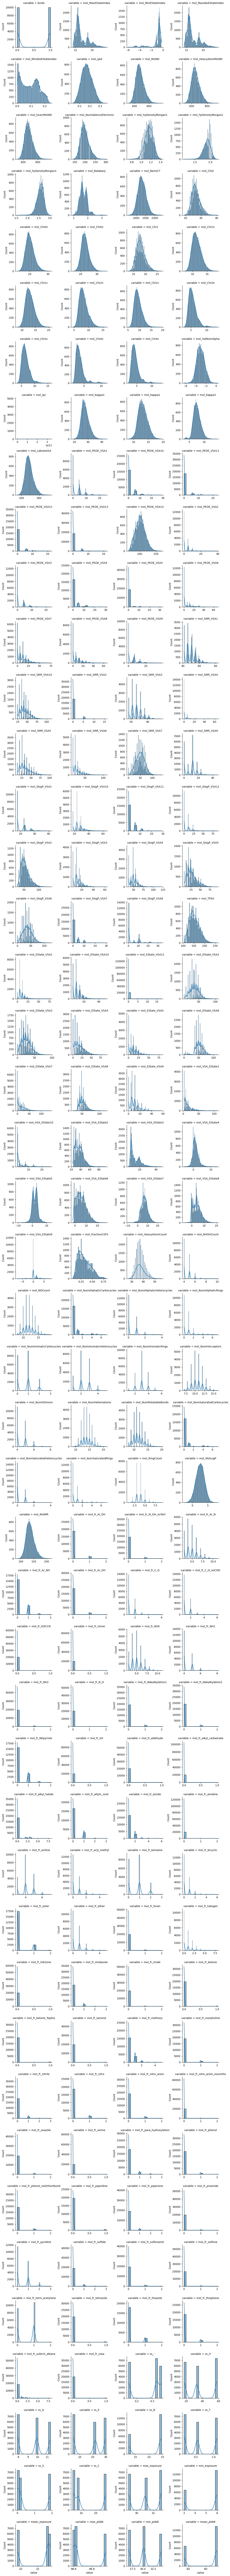

In [32]:
f = pd.melt(frame=df_cleaned)
g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, 'value', kde=True)

# First Round of Simple Models

In [34]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statistics import mean

In [36]:
X = df_cleaned.drop('binds', axis=1)
y = df_cleaned['binds']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Custom Dataset
class BindingDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels).unsqueeze(1)  # Ensure labels are 2D

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoaders
train_dataset = BindingDataset(X_train_scaled, y_train.values)
val_dataset = BindingDataset(X_val_scaled, y_val.values)
test_dataset = BindingDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Train set shape: (12000, 183)
Validation set shape: (4000, 183)
Test set shape: (4000, 183)


In [45]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

def get_accuracy(outputs, y):
    predicted = (outputs > 0.5).float()
    return (predicted == y).float().mean().item()

def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    losses = []
    accuracies = []

    for data, target in dataloader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(get_accuracy(output, target))

    return mean(losses), mean(accuracies)



def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    losses = []
    accuracies = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            loss = loss_fn(output, target)

            losses.append(loss.item())
            accuracies.append(get_accuracy(output, target))

    return mean(losses), mean(accuracies)

def train_model(model, train_loader, val_loader, test_loader, epochs,
                lr, weight_decay, device='cuda'):
    model.to(device)
    loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    best_val_accuracy = -1

    for epoch in range(epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn, device)
        test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            msg = "New best model saved!"
        else:
            msg = ""

        print(
            f"Epoch {epoch+1:02d}: train loss {train_loss:.4f} train acc {train_accuracy:.4f} "
            f"val loss {val_loss:.4f} val acc {val_accuracy:.4f} "
            f"test loss {test_loss:.4f} test acc {test_accuracy:.4f} {msg}"
        )

def count_parameters(model):
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The number of trainable parameters.

    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [38]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train.shape[1]  # number of features
model = MLP(input_size=input_size, hidden_size=128, output_size=1)
print(f"The model has {count_parameters(model):,} trainable parameters")

# Train the model
train_model(model, train_loader, val_loader, test_loader, epochs=50, device=device)

# Make predictions
model.eval()
with torch.no_grad():
    new_data = torch.randn(5, input_size).to(device)
    predictions = model(new_data)
    print("Predictions:", predictions)
    binary_predictions = (predictions > 0.5).float()
    print("Binary Predictions:", binary_predictions)

The model has 40,193 trainable parameters
Epoch 01: train loss 0.4790 train acc 0.7688 val loss 0.4214 val acc 0.8063 test loss 0.4406 test acc 0.7980 New best model saved!
Epoch 02: train loss 0.3633 train acc 0.8408 val loss 0.3594 val acc 0.8460 test loss 0.3660 test acc 0.8353 New best model saved!
Epoch 03: train loss 0.3212 train acc 0.8613 val loss 0.3497 val acc 0.8488 test loss 0.3609 test acc 0.8380 New best model saved!
Epoch 04: train loss 0.2924 train acc 0.8722 val loss 0.3438 val acc 0.8550 test loss 0.3536 test acc 0.8478 New best model saved!
Epoch 05: train loss 0.2699 train acc 0.8856 val loss 0.3476 val acc 0.8570 test loss 0.3559 test acc 0.8460 New best model saved!
Epoch 06: train loss 0.2468 train acc 0.8955 val loss 0.3520 val acc 0.8568 test loss 0.3625 test acc 0.8417 
Epoch 07: train loss 0.2285 train acc 0.9024 val loss 0.3348 val acc 0.8620 test loss 0.3500 test acc 0.8518 New best model saved!
Epoch 08: train loss 0.2107 train acc 0.9126 val loss 0.3782 v

# Results:

Size of Dataset = 2,000: Epoch 15: train loss 0.0409 train acc 0.9910 val loss 1.3169 val acc 0.8005 test loss 1.0893 test acc 0.7596 New best model saved!


Size of Dataset = 20,000: Epoch 17: train loss 0.1009 train acc 0.9630 val loss 0.5201 val acc 0.8622 test loss 0.5399 test acc 0.8488 New best model saved!

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [40]:
# Combine training and validation sets for GridSearchCV
X_train_full = np.vstack((X_train_scaled, X_val_scaled))
y_train_full = np.concatenate((y_train, y_val))

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Now you can proceed with your SVM
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluate
y_pred = svm.predict(X_test_scaled)
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1945
           1       0.88      0.84      0.86      2055

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



# Results:

Size of Dataset = 2,000:

Classification Report:

                precision    recall  f1-score   support

           0       0.74      0.75      0.75       203
           1       0.74      0.73      0.74       197

    accuracy                           0.74       400
    macro avg      0.74      0.74      0.74       400
    weighted avg   0.74      0.74      0.74       400

Size of Dataset = 20,000:

Classification Report:

                precision    recall  f1-score   support

           0       0.84      0.87      0.86      1945
           1       0.88      0.84      0.86      2055

    accuracy                           0.86      4000
    macro avg        0.86      0.86    0.86      4000
    weighted avg     0.86      0.86    0.86      4000

In [41]:
# Feature selection
selector = SelectKBest(f_classif, k='all')  # Start with all features, we'll analyze importance later
X_train_selected = selector.fit_transform(X_train_full, y_train_full)
X_test_selected = selector.transform(X_test_scaled)

# Handle potential class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train_full)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}

# Create SVM model
svm = SVC(random_state=42, probability=True)

# Set up GridSearchCV with stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_svm = grid_search.best_estimator_

# Make predictions
y_pred = best_svm.predict(X_test_selected)
y_prob = best_svm.predict_proba(X_test_selected)[:, 1]

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance analysis
feature_importance = selector.scores_
feature_indices = np.argsort(feature_importance)[::-1]
importance_df = pd.DataFrame({
    'feature': [f'feature_{i}' for i in feature_indices],
    'importance': feature_importance[feature_indices]
})
print("\nTop 10 Important Features:")
print(importance_df.head(10))

# Optionally, retrain with top features
top_k_features = 10  # or however many you want
selector = SelectKBest(f_classif, k=top_k_features)
X_train_top = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_top = selector.transform(X_test_selected)

best_svm.fit(X_train_top, y_train_resampled)
y_pred_top = best_svm.predict(X_test_top)

print("\nClassification Report with Top Features:")
print(classification_report(y_test, y_pred_top))

# Example of using the model for prediction
new_data = np.random.randn(5, X_test_scaled.shape[1])  # 5 new samples
new_data_selected = selector.transform(new_data)
predictions = best_svm.predict(new_data_selected)
probabilities = best_svm.predict_proba(new_data_selected)[:, 1]

print("\nPredictions for new data:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Sample {i+1}: Prediction = {pred}, Probability = {prob:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits


KeyboardInterrupt: 

# Results:

Size of Dataset = 2,000:

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

Best cross-validation score: 0.8011920723404271

Classification Report:

                precision    recall  f1-score   support

           0       0.77      0.82      0.79       203
           1       0.80      0.75      0.77       197

    accuracy                           0.78       400
    macro avg      0.78      0.78      0.78       400
    weighted avg   0.78      0.78      0.78       400



In [ ]:
# Use PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Train SVM on reduced data
svm = SVC(kernel='rbf')
svm.fit(X_pca, y_train)

# Create a mesh to plot in
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict the function value for the whole grid
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolor='black')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('SVM Decision Boundary (PCA-reduced to 2D)')
plt.show()

In [ ]:
# Train SVM
svm = SVC(probability=True)  # We need probability estimates
svm.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_proba = svm.predict_proba(X_test_scaled)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Train SVM
svm = SVC()
svm.fit(X_train_scaled, y_train)

# Predict
y_pred = svm.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Second Round of Models:

In [46]:
#@title We Add in L1 and L2 Regularisation Into Our Vanilla MLP to Reduce the Overfitting

class RegularizedMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

def tune_hyperparameters(input_size, hidden_size, output_size, train_loader, val_loader, device):
    learning_rates = [0.1, 0.01, 0.001]
    weight_decays = [0.0, 1e-4, 1e-3]
    dropout_rates = [0.3, 0.5]

    best_val_accuracy = -1
    best_params = {}

    for lr in learning_rates:
        for wd in weight_decays:
            for dr in dropout_rates:
                print(f"\nTrying lr={lr}, weight_decay={wd}, dropout_rate={dr}")
                model = RegularizedMLP(input_size, hidden_size, output_size, dropout_rate=dr).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

                # Train for a few epochs
                for epoch in range(10):
                    train_epoch(model, train_loader, nn.BCELoss(), optimizer, device)
                    val_loss, val_accuracy = evaluate_model(model, val_loader, nn.BCELoss(), device)
                    scheduler.step(val_accuracy)

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_params = {'lr': lr, 'weight_decay': wd, 'dropout_rate': dr}

    print(f"\nBest parameters: {best_params}")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")

    return best_params

# Assuming you have already defined train_epoch, evaluate_model, and train_model functions

# Main execution
if __name__ == "__main__":
    # Load your data and create data loaders (train_loader, val_loader, test_loader)
    # ...

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get input size from your data
    input_size = X_train.shape[1]  # number of features
    hidden_size = 128
    output_size = 1

    # Perform hyperparameter tuning
    best_params = tune_hyperparameters(input_size, hidden_size, output_size, train_loader, val_loader, device)

    # Initialize the model with best parameters
    model = RegularizedMLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                           dropout_rate=best_params['dropout_rate']).to(device)
    print(f"The model has {count_parameters(model):,} trainable parameters")

    # Train the model
    train_model(model, train_loader, val_loader, test_loader, epochs=50,
                lr=best_params['lr'], weight_decay=best_params['weight_decay'], device=device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        new_data = torch.randn(5, input_size).to(device)
        predictions = model(new_data)
        print("Predictions:", predictions)
        binary_predictions = (predictions > 0.5).float()
        print("Binary Predictions:", binary_predictions)


Trying lr=0.1, weight_decay=0.0, dropout_rate=0.3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Trying lr=0.1, weight_decay=0.0, dropout_rate=0.5

Trying lr=0.1, weight_decay=0.0001, dropout_rate=0.3

Trying lr=0.1, weight_decay=0.0001, dropout_rate=0.5

Trying lr=0.1, weight_decay=0.001, dropout_rate=0.3

Trying lr=0.1, weight_decay=0.001, dropout_rate=0.5

Trying lr=0.01, weight_decay=0.0, dropout_rate=0.3

Trying lr=0.01, weight_decay=0.0, dropout_rate=0.5

Trying lr=0.01, weight_decay=0.0001, dropout_rate=0.3

Trying lr=0.01, weight_decay=0.0001, dropout_rate=0.5

Trying lr=0.01, weight_decay=0.001, dropout_rate=0.3

Trying lr=0.01, weight_decay=0.001, dropout_rate=0.5

Trying lr=0.001, weight_decay=0.0, dropout_rate=0.3

Trying lr=0.001, weight_decay=0.0, dropout_rate=0.5

Trying lr=0.001, weight_decay=0.0001, dropout_rate=0.3

Trying lr=0.001, weight_decay=0.0001, dropout_rate=0.5

Trying lr=0.001, weight_decay=0.001, dropout_rate=0.3

Trying lr=0.001, weight_decay=0.001, dropout_rate=0.5

Best parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'dropout_rate': 0.3}
Best val

# Results:

Size of Dataset = 2,000: Epoch 50: train loss 0.0849 train acc 0.9696 val loss 1.0417 val acc 0.7933 test loss 0.8263 test acc 0.7764 No improvement for 16 epochs

Size of Dataset = 20,000: Epoch 40: train loss 0.2419 train acc 0.8988 val loss 0.2961 val acc 0.8800 test loss 0.3059 test acc 0.8755 New best model saved!

In [76]:
from torch_geometric.loader import DataLoader as GraphDataLoader

class MoleculeGCN(nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(MoleculeGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)


    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return global_mean_pool(x, batch)

# Get all the molecules and find their node, edge and structural features as a graph for GCN
def get_molecule_graphs(mols):
    results = []
    for mol in mols:
        if mol is not None:
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol, randomSeed=42)
            AllChem.MMFFOptimizeMolecule(mol)

            conf = mol.GetConformer()
            node_features = []
            node_positions = []
            for atom in mol.GetAtoms():
                features = [
                    atom.GetAtomicNum(),
                    atom.GetTotalNumHs(),
                    int(atom.GetIsAromatic())
                ]
                node_features.append(features)
                position = conf.GetAtomPosition(atom.GetIdx())
                node_positions.append([position.x, position.y, position.z])

            edges = []
            for bond in mol.GetBonds():
                i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                edges.extend([[i, j], [j, i]])

            node_features = torch.tensor(node_features, dtype=torch.float)
            node_positions = torch.tensor(node_positions, dtype=torch.float)
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

            data = Data(x=node_features, pos=node_positions, edge_index=edge_index)
            results.append(data)
        else:
            results.append(None)

    return results

def process_molecules(smiles_list, gcn_model):
    mols = [Chem.MolFromSmiles(s) for s in smiles_list if s]
    molecule_graphs = get_molecule_graphs(mols)

    # Filter out None values
    molecule_graphs = [graph for graph in molecule_graphs if graph is not None]

    loader = GraphDataLoader(molecule_graphs, batch_size=32)

    molecule_features = []
    gcn_model.eval()
    with torch.no_grad():
        for batch in loader:
            out = gcn_model(batch.x, batch.edge_index, batch.batch)
            molecule_features.append(out)

    return torch.cat(molecule_features, dim=0)


In [77]:
class BindingPredictor(nn.Module):
    def __init__(self, input_size):
        super(BindingPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / len(loader), correct / total

In [79]:
# Load your data
df = pd.read_csv('./kaggle_data/train.csv', nrows=10000000)

# Balance the dataset
df_bind = df[df['binds'] == 1]
df_no_bind = df[df['binds'] == 0]
n_samples = min(10000, len(df_bind), len(df_no_bind))
df_bind_sample = df_bind.sample(n_samples, random_state=42)
df_no_bind_sample = df_no_bind.sample(n_samples, random_state=42)
df = pd.concat([df_bind_sample, df_no_bind_sample]).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create and initialize the GCN model
num_node_features = 3  # Matches the number of features in get_molecule_graphs
hidden_channels = 64
gcn_model = MoleculeGCN(num_node_features, hidden_channels)

# Process molecules through GCN
gcn_features = process_molecules(df['molecule_smiles'].tolist(), gcn_model)

# Create a new dataframe with GCN features
gcn_df = pd.DataFrame(gcn_features.numpy(), columns=[f'gcn_feat_{i}' for i in range(gcn_features.shape[1])])

# Combine GCN features with protein_name and binds columns
new_df = pd.concat([gcn_df, df[['protein_name', 'binds']]], axis=1)

print("New DataFrame Shape:", new_df.shape)
print("\nNew DataFrame Columns:")
print(new_df.columns)
print("\nSample of New DataFrame:")
print(new_df.head())

# Prepare data for model
X = new_df.drop(['protein_name', 'binds'], axis=1)
y = new_df['binds']

# One-hot encode the protein_name
protein_encoded = pd.get_dummies(new_df['protein_name'], prefix='protein')
X = pd.concat([X, protein_encoded], axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.values))
val_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val.values))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(y_test.values))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Initialize the binding predictor
input_size = X_train_scaled.shape[1]
binding_model = BindingPredictor(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(binding_model.parameters(), lr=0.001)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
binding_model.to(device)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train_epoch(binding_model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(binding_model, val_loader, criterion, device)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Final evaluation on test set
test_loss, test_accuracy = evaluate(binding_model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Streaming output truncated to the last 5000 lines.
[14:07:04] UFFTYPER: Unrecognized charge state for atom: 32
[14:07:04] UFFTYPER: Unrecognized atom type: Dy5+3 (32)
[14:07:05] UFFTYPER: Unrecognized charge state for atom: 38
[14:07:05] UFFTYPER: Unrecognized atom type: Dy5+3 (38)
[14:07:05] UFFTYPER: Unrecognized charge state for atom: 32
[14:07:05] UFFTYPER: Unrecognized atom type: Dy5+3 (32)
[14:07:05] UFFTYPER: Unrecognized charge state for atom: 34
[14:07:05] UFFTYPER: Unrecognized atom type: Dy5+3 (34)
[14:07:06] UFFTYPER: Unrecognized charge state for atom: 36
[14:07:06] UFFTYPER: Unrecognized atom type: Dy5+3 (36)
[14:07:06] UFFTYPER: Unrecognized charge state for atom: 50
[14:07:06] UFFTYPER: Unrecognized atom type: Dy5+3 (50)
[14:07:06] UFFTYPER: Unrecognized charge state for atom: 8
[14:07:06] UFFTYPER: Unrecognized atom type: Dy5+3 (8)
[14:07:07] UFFTYPER: Unrecognized charge state for atom: 34
[14:07:07] UFFTYPER: Unrecognized atom type: Dy5+3 (34)
[14:07:07] UFFTYPER: Un

New DataFrame Shape: (20000, 66)

New DataFrame Columns:
Index(['gcn_feat_0', 'gcn_feat_1', 'gcn_feat_2', 'gcn_feat_3', 'gcn_feat_4',
       'gcn_feat_5', 'gcn_feat_6', 'gcn_feat_7', 'gcn_feat_8', 'gcn_feat_9',
       'gcn_feat_10', 'gcn_feat_11', 'gcn_feat_12', 'gcn_feat_13',
       'gcn_feat_14', 'gcn_feat_15', 'gcn_feat_16', 'gcn_feat_17',
       'gcn_feat_18', 'gcn_feat_19', 'gcn_feat_20', 'gcn_feat_21',
       'gcn_feat_22', 'gcn_feat_23', 'gcn_feat_24', 'gcn_feat_25',
       'gcn_feat_26', 'gcn_feat_27', 'gcn_feat_28', 'gcn_feat_29',
       'gcn_feat_30', 'gcn_feat_31', 'gcn_feat_32', 'gcn_feat_33',
       'gcn_feat_34', 'gcn_feat_35', 'gcn_feat_36', 'gcn_feat_37',
       'gcn_feat_38', 'gcn_feat_39', 'gcn_feat_40', 'gcn_feat_41',
       'gcn_feat_42', 'gcn_feat_43', 'gcn_feat_44', 'gcn_feat_45',
       'gcn_feat_46', 'gcn_feat_47', 'gcn_feat_48', 'gcn_feat_49',
       'gcn_feat_50', 'gcn_feat_51', 'gcn_feat_52', 'gcn_feat_53',
       'gcn_feat_54', 'gcn_feat_55', 'gcn_feat_56', 

# Results:

Note: This is based just off the molecule_smiles structure of the molecules and the atom (node) and bond (edge) features as graphs after being passed through a GCN and then a MLP.

Size of Dataset = 20,000: Epoch [100/100], Train Loss: 0.6391, Val Loss: 0.6377, Val Accuracy: 0.6200 Test Loss: 0.6434, Test Accuracy: 0.6278


# Notes Up Till Now:

So what we have seen when we train at a level of just 20,000 rows of data split 50/50 with bind and no bind datapoints. We see after testing a few architectures that we have the following:

Accuracies:

1.   Hyperparameter tuned Regression MLP ≅ 0.88
2.   Vanilla MLP ≅ 0.86
3. SVM ≅ 0.86
4. GCN + MLP ≅ 0.63


With this we can see a few things:

1.   the data we collected earlier with regards to the protein and molecules was more useful in training some models initially.
2.   We need to consider that the GCN did not use many input features of the molecules from rdkit which we should do tests on in accord with the GCN output features.
3. Lastly, we also just note that the Hyperparameter tunned MLP model did not overfit like the Vanilla MLP which is great news and thus with teh data we have its best we use regression techniques, that have been hyperparameter tuned as we did.



